In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# creamos el dataset
dataset = dset.ImageFolder(root='/content/drive/MyDrive/Data/CelebA',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [ ]:
# creamos el dataloader
# num_workers = el número de subprocesos de trabajo para cargar los datos con DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# creamos una función para desnormalizar las imágenes
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

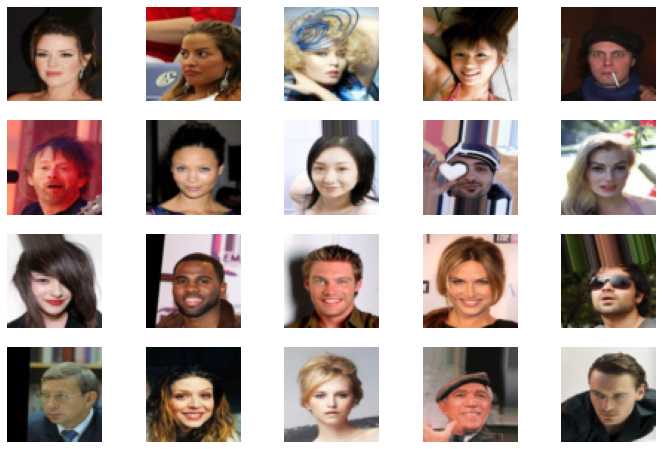

In [ ]:
# obtenemos un batch de imágenes del dataloader
dataiter = iter(dataloader)
images, _ = dataiter.__next__()

# seleccionamos 20 imágenes al azar del batch
indices = torch.randperm(128)[:20]
sample_images = images[indices]

# mostramos las imágenes en una grilla de 4x5
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(denorm(sample_images[i]).permute(1, 2, 0))
    ax.axis('off')
plt.show()

Este método es importante porque permite inicializar los pesos de una red neuronal con una distribución normal que depende del número de entradas y salidas de cada capa. Esto ayuda a evitar que los pesos sean demasiado grandes o pequeños, lo que podría causar problemas de saturación o desvanecimiento de los gradientes durante el entrenamiento.

[Inicialización de los pesos y bias](https://keepcoding.io/blog/inicializacion-pesos-bias-deep-learning/)

In [ ]:
# FUNCION PARA INICIALIZAR LOS PESOS
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # inicializa los pesos de la capa con una distribución normal con media 0 y desviación estándar 0.02
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
      # nicializa los pesos de la capa con una distribución normal con media 1 y desviación estándar 0.02, y los sesgos de la capa con un valor constante de 0,
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# GENERADOR

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # capa 1: convolucion transpuesta
            # recibe un vector de ruido de 100 dimensiones y lo transforma en un tensor de 64*8 canales y 4x4 pixeles
            nn.ConvTranspose2d(in_channels=100, out_channels=64 * 8, kernel_size=4, stride=1, padding=0, bias=False),
            # capa 2: normalizacion por lotes, normaliza las activaciones de la capa anterior por cada canal y cada lote
            nn.BatchNorm2d(num_features=64 * 8),
            # capa 3: funcion de activacion ReLU
            # aplica la funcion max(0,x) a cada elemento del tensor
            nn.ReLU(inplace=True),
            

            nn.ConvTranspose2d(in_channels=64 * 8, out_channels=64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64 * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64 * 4, out_channels=64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64 * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d( in_channels=64 * 2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            # aumenta el tamaño del tensor a 64x64 píxeles y reduce el número de canales a 3 (RGB)
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            # escala los valores del tensor entre -1 y 1
            nn.Tanh() 
        )

    def forward(self, input): 
      # El método forward recibe como argumento un vector de ruido de 100 dimensiones y lo transforma en una imagen de 3 canales y 64x64 píxeles.
        return self.main(input)

In [ ]:
# Crear una instancia de la clase Generator y moverla al dispositivo
netG = Generator().to(device)
# Aplicar la función weights_init para inicializar los pesos de forma aleatoria
# con una mean=0, y una stdev=0.02.
netG.apply(weights_init)

# Imprimir el modelo
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # definimos la arquitectura del discriminador
        self.main = nn.Sequential(
            # Convolucion, recibe una imagen de 3 canales y 64x64 pixeles y la transforma en un tensor de 64 canales y 32x32 pixeles
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            # aplica la funcion max(0.2*x,x) a cada elemento del tensor
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # aumenta el numero de canales del tensor a 64*2 y reduce el tamaño a 16x16 pixeles
            nn.Conv2d(in_channels=64, out_channels=64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            # normaliza las activaciones de la capa anterior por cada canal y cada lote
            nn.BatchNorm2d(num_features=64 * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
                       
            nn.Conv2d(in_channels=64 * 2, out_channels=64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64 * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),


            nn.Conv2d(in_channels=64 * 4, out_channels=64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64 * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # reduce el numero de canales del tensor a 1 y el tamaño a 1x1 pixel
            nn.Conv2d(in_channels=64 * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Creamos una instancia de la clase Discriminator y moverla al dispositivo
netD = Discriminator().to(device)
# Aplicar la función weights_init para inicializar los pesos de forma aleatoria
#  con media=0 y desviación estándar=0.2
netD.apply(weights_init)

# Imprimir el modelo
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Inicializar la función de pérdida BCELoss
criterion = nn.BCELoss()

# Crear un lote de vectores latentes que usaremos para visualizar el progreso del generador DCGAN.
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establecer la convención para las etiquetas reales y falsas durante el entrenamiento
real_label = 1.
fake_label = 0.

# Configurar los optimizadores Adam para ambos modelos G y D
# Estos optimizadores usan una tasa de aprendizaje de 0.0002 y unos factores de momento de 0.5 y 0.999
# Los factores de momento, (beta1) determina cuánto se conserva el gradiente anterior, (beta2) determina cuánto se corrige el gradiente actual por la varianza del gradiente anterior.
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise almacena un lote de 64 vectores latentes, que son los que se usan para generar imágenes con el generador. Un vector latente es una representación de baja dimensión de un dato de alta dimensión, que captura las características esenciales del dato. En este caso, el vector latente tiene 100 dimensiones y la imagen generada tiene 3 canales y 64x64 píxeles. El generador aprende a mapear el vector latente a una imagen que parezca real.

# Entrenamiento

In [ ]:
# para almacenar las imagenes falsas
img_list = []
# lista que guarda las pérdidas del generador en cada iteración.
G_losses = []
# lista que guarda las pérdidas del discriminador en cada iteración
D_losses = []
# contador, ee usa para saber cuándo guardar una imagen falsa o imprimir las estadísticas. 
iters = 0

# Iterar sobre las épocas, Cada época se divide en 235 iteraciones, que es el número de lotes que se obtienen del dataloader.
for epoch in range(5):
    # Iterar sobre el dataloader
    for i, data in enumerate(dataloader, 0):
        # Poner a cero los gradientes del discriminador
        netD.zero_grad()
        # Obtener los datos reales y moverlos al dispositivo
        real_cpu = data[0].to(device)
        # Obtener el tamaño del batch
        b_size = real_cpu.size(0)

        # Crear las etiquetas reales y moverlas al dispositivo
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Pasar los datos reales por el discriminador y obtener la salida
        output = netD(real_cpu).view(-1)
        # Calcular el error del discriminador con los datos reales
        errD_real = criterion(output, label)
        # Propagar el error hacia atrás
        errD_real.backward()
        # Obtener la media de la salida del discriminador con los datos reales
        D_x = output.mean().item()

        # Generar ruido aleatorio y moverlo al dispositivo
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Pasar el ruido por el generador y obtener los datos falsos
        fake = netG(noise)
        # Crear las etiquetas falsas 
        label.fill_(fake_label)
        # Pasar los datos falsos por el discriminador y obtener la salida
        output = netD(fake.detach()).view(-1)
        # Calcular el error del discriminador con los datos falsos
        errD_fake = criterion(output, label)
        # Propagar el error hacia atrás
        errD_fake.backward()
        # Obtener la media de la salida del discriminador con los datos falsos
        D_G_z1 = output.mean().item()
        # Sumar los errores del discriminador con los datos reales y falsos
        errD = errD_real + errD_fake
        # Actualizar los parámetros del discriminador con el optimizador
        optimizerD.step()

        # Poner a cero los gradientes del generador
        netG.zero_grad()
        # Crear las etiquetas reales y moverlas al dispositivo
        label.fill_(real_label)
        # Pasar los datos falsos por el discriminador y obtener la salida
        output = netD(fake).view(-1)
        # Calcular el error del generador con la salida del discriminador
        errG = criterion(output, label)
        # Propagar el error hacia atrás
        errG.backward()
        # Obtener la media de la salida del discriminador con los datos falsos
        D_G_z2 = output.mean().item()
        # Actualizar los parámetros del generador con el optimizador
        optimizerG.step()

        # Guardar un checkpoint cada 500 iteraciones o al final del entrenamiento
        if (iters % 500 == 0) or ((epoch == 5-1) and (i == len(dataloader)-1)):
            # Crear el diccionario con la información del modelo
            checkpoint = {
                'epoch': epoch,
                'iter': iters,
                'G_state_dict': netG.state_dict(),
                'D_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_loss': errG.item(),
                'D_loss': errD.item()
            }

            # Crear el nombre del archivo 
            filename = '/content/drive/MyDrive/Data/Checkpoint/entrenamiento1.tar'
            torch.save(checkpoint, filename)

        # Imprimir las estadísticas cada 50 iteraciones
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 5, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Guardar las pérdidas del generador y el discriminador en listas
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Guardar una imagen falsa cada 500 iteraciones o al final del entrenamiento
        if (iters % 500 == 0) or ((epoch == 5-1) and (i == len(dataloader)-1)):
            # Desactivar el cálculo de gradientes
            with torch.no_grad():
                # Genera una imagen falsa con el ruido fijo y lo mueve a la CPU
                fake = netG(fixed_noise).detach().cpu()
            # Añade la imagen falsa a la lista de imágenes
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

[0/5][0/235]	Loss_D: 0.0103	Loss_G: 22.7272	D(x): 0.9987	D(G(z)): 0.0088 / 0.0000
[0/5][50/235]	Loss_D: 0.2639	Loss_G: 5.2825	D(x): 0.9144	D(G(z)): 0.0979 / 0.0121
[0/5][100/235]	Loss_D: 0.4342	Loss_G: 4.0074	D(x): 0.7863	D(G(z)): 0.0550 / 0.0414
[0/5][150/235]	Loss_D: 0.2612	Loss_G: 5.4411	D(x): 0.8522	D(G(z)): 0.0399 / 0.0093
[0/5][200/235]	Loss_D: 0.4942	Loss_G: 5.1604	D(x): 0.8199	D(G(z)): 0.1731 / 0.0137
[1/5][0/235]	Loss_D: 0.4275	Loss_G: 3.6944	D(x): 0.7868	D(G(z)): 0.0912 / 0.0540
[1/5][50/235]	Loss_D: 0.3934	Loss_G: 3.2670	D(x): 0.8420	D(G(z)): 0.1122 / 0.0714
[1/5][100/235]	Loss_D: 0.2879	Loss_G: 4.6195	D(x): 0.8776	D(G(z)): 0.1159 / 0.0202
[1/5][150/235]	Loss_D: 0.3968	Loss_G: 4.7880	D(x): 0.8687	D(G(z)): 0.1654 / 0.0156
[1/5][200/235]	Loss_D: 0.1918	Loss_G: 5.8436	D(x): 0.9755	D(G(z)): 0.1358 / 0.0054
[2/5][0/235]	Loss_D: 0.4492	Loss_G: 5.8106	D(x): 0.9545	D(G(z)): 0.2617 / 0.0068
[2/5][50/235]	Loss_D: 0.5850	Loss_G: 3.8639	D(x): 0.7589	D(G(z)): 0.1182 / 0.0544
[2/5][100/23

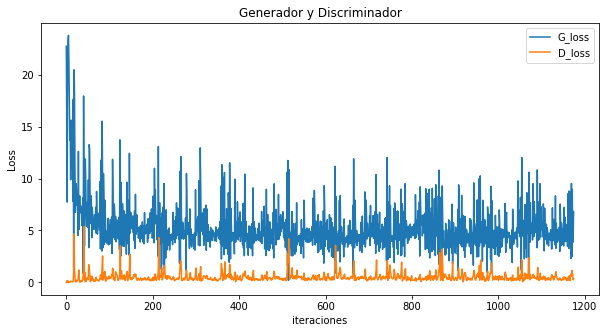

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generador y Discriminador")
plt.plot(G_losses,label="G_loss")
plt.plot(D_losses,label="D_loss")
plt.xlabel("iteraciones")
plt.ylabel("Loss")
plt.legend()
plt.show()

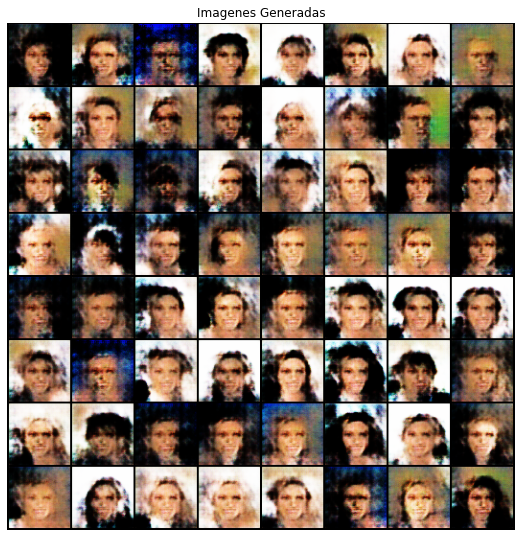

In [ ]:
# IMAGENES GENERADAS
plt.figure(figsize=(20,20))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imagenes Generadas")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

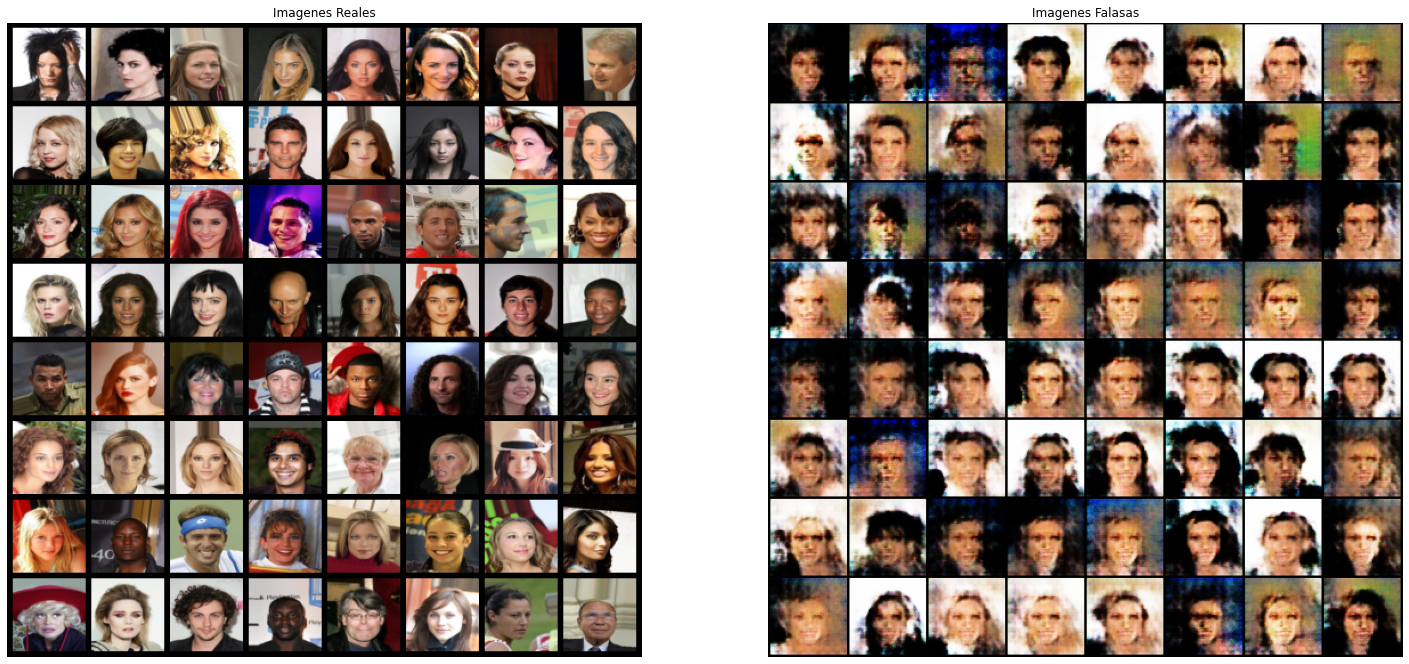

In [ ]:
# Obtener un batch de imágenes reales del dataloader
real_batch = next(iter(dataloader))

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(25,25))
# Crear un subplot para las imágenes reales
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imagenes Reales")
# Mostrar las imágenes reales usando vutils.make_grid para crear una cuadrícula de imágenes
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Crear un subplot para las imágenes falsas
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imagenes Falasas")
# Mostrar las imágenes falsas usando vutils.make_grid para crear una cuadrícula de imágenes
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()